In [15]:
import pandas as pd
import numpy as np
import datetime
import os

In [16]:
def process_trip(single_trip):
    
    single_trip = single_trip[single_trip['timint']<2]
    arrivals = single_trip[['station_char']].drop_duplicates()
    
    arrival_max = single_trip.sort_values(by = 'request_date', ascending = False)
    arrival_max = arrival_max.drop_duplicates(subset = ['station_char'])[['station_char', 'estimated_arrival']]


    arrivals_at_station = single_trip[single_trip['timint']==0]
    arrivals_at_station = arrivals_at_station.sort_values(by = 'estimated_arrival')
    arrivals_at_station  = arrivals_at_station.drop_duplicates(subset = ['station_char'])[['station_char', 'estimated_arrival']]

    arrivals = arrivals.merge(arrival_max, how = 'left')

    arrivals_at_station = arrivals_at_station.rename(columns = {'estimated_arrival':'at_station_time'})
    arrivals = arrivals.merge(arrivals_at_station, how = 'left')
    arrivals['arrival'] = True
    
    arrivals['arrival_time'] = np.where(arrivals['at_station_time'].isna(),
                                        arrivals['estimated_arrival'], arrivals['at_station_time'])



    arrivals = arrivals.sort_values(by = 'estimated_arrival').reset_index(drop = True)
    
    arrivals = arrivals[['station_char', 'arrival', 'arrival_time']].rename(columns =
                                                                        {'arrival_time':'estimated_arrival'})
    if len(arrivals) != 0:
        single_trip = single_trip.merge(arrivals)
    else:
        return -1 # no eligible arrivals, continue to next trip

    single_trip = single_trip.sort_values(by = 'estimated_arrival')
    
    single_trip = single_trip[['station_char', 'subwayline', 'timint','stationid', 'traindirection', 'trip','trainid',
                 'estimated_arrival', 'arrival']]
    
    single_trip = single_trip.reset_index().merge(single_trip.shift(-1).reset_index()[['station_char',
                                                                                       'estimated_arrival','stationid',
                                                                                       'index']], 
                                left_on = 'index', right_on = 'index', suffixes = ['_o', '_d'])
    single_trip = single_trip.dropna()
    return single_trip

In [17]:
def clean_df(df):

    df['request_date'] = pd.to_datetime(df['request_date'])
    df = df.sort_values(by = 'timint')
    df['platformid'] = df['station_char'].str[3]

    df_newest = df.drop_duplicates(subset = ['requestid', 'station_char'])

    return df_newest

In [18]:
def train_processing(df_newest):
    print(df_newest)
    train_list = []
    for line in list(df_newest['subwayline'].drop_duplicates()):
        df_line = df_newest[df_newest['subwayline'] == line]

        train_ids = df_line['trainid'].drop_duplicates()

        for train_id in train_ids:
            print(train_id)
            single_train = df_line[df_line['trainid'] == train_id]

            single_train['estimated_arrival'] = single_train['request_date'] + pd.to_timedelta(single_train['timint'], 'm')

            single_train = single_train.sort_values(by = 'request_date')

            single_train['trip'] = ((single_train['traindirection'] != single_train['traindirection'].shift(1))
                                   | ((single_train['request_date'] - single_train['request_date'].shift(1)).dt.seconds > 1800)
                                   ).cumsum() - 1        
            trip_num = single_train['trip'].max()


            arrival_list = []
            arrival_limit = None
            for i in range(trip_num + 1):
                print(train_id, i)
                if i == 0:
                    current_arrivals = process_trip(single_train[single_train['trip'] == i])
                    if isinstance(current_arrivals, int):
                        print('cont')
                        continue

                elif isinstance(current_arrivals, int): # when the previous current arrivals does not return a result
                    current_arrivals = process_trip(single_train[single_train['trip'] == i])
                    if isinstance(current_arrivals, int): # if the successives trip still does not return a result
                        print('cont')
                        continue
                else:
                    if i < trip_num:
                        next_arrivals = process_trip(single_train[single_train['trip'] == i + 1])
                    try:
                        arrival_limit = next_arrivals.head(1)[['estimated_arrival_d']].iloc[0,0] - datetime.timedelta(seconds = 45)

                    except: # if the next trip doesn't return a result, then the arrival limit id not used

                        if len(current_arrivals['station_char_d']) == 0:
                            pass
                        else:
                            arrival_limit = current_arrivals.tail(1)[['estimated_arrival_d']].iloc[0,0] + datetime.timedelta(seconds = 45)

                    if len(current_arrivals['station_char_d']) == 1:
                        pass
                    elif len(current_arrivals['station_char_d']) == 0:
                        pass

                    elif i < trip_num:

                        current_arrivals = current_arrivals[current_arrivals['estimated_arrival_d'] < arrival_limit]
                    else:
                        pass
                    if i < trip_num:
                        past_arrivals = current_arrivals
                        current_arrivals = next_arrivals
                    else:
                        pass
                try:
                    arrival_list.append(past_arrivals)
                except:
                    arrival_list.append(current_arrivals.copy())





            if len(arrival_list) == 0:
                continue
            else:
                arrival_trip = pd.concat(arrival_list)

            if arrival_trip['estimated_arrival_d'].max().hour < 11:
                if arrival_trip['subwayline'].drop_duplicates().iloc[0] == 'BD':
                    cutoff = arrival_trip[arrival_trip['stationid_d'] == 55]['estimated_arrival_d'].max()

                elif (arrival_trip['subwayline'].drop_duplicates().iloc[0] == 'YUS') & (arrival_trip.tail(1)['stationid_d'].iloc[0] == 80):
                    cutoff = arrival_trip[arrival_trip['stationid_d'] == 80]['estimated_arrival_d'].max()

                elif arrival_trip['subwayline'].drop_duplicates().iloc[0] == 'YUS':
                    cutoff = arrival_trip[arrival_trip['stationid_d'] == 1]['estimated_arrival_d'].max()
                else:
                    cutoff = arrival_trip['estimated_arrival_d'].max()
            else:
                cutoff = arrival_trip['estimated_arrival_d'].max()

            arrival_trip = arrival_trip[arrival_trip['estimated_arrival_d'] <= cutoff]


            arrival_trip = arrival_trip.reset_index(drop = True)

            arrival_trip = arrival_trip.merge(stn_lookup[['station_char', 'sequence']], left_on = ['station_char_o'], 
                       right_on = ['station_char']).drop(columns = ['station_char']).rename(
                columns = {'sequence':'sequence_o'})

            arrival_trip = arrival_trip.merge(stn_lookup[['station_char', 'sequence']], left_on = ['station_char_d'], 
                               right_on = ['station_char']).drop(columns = ['station_char']).rename(
                columns = {'sequence':'sequence_d'})

            train_list.append(arrival_trip)
            
    return train_list

In [19]:
stn_lookup = pd.read_csv('train_arrival_stations_lookup.csv')

In [20]:
%%capture

file_list = os.listdir('cleaned_subway')
error_list = []
for file in file_list:
    date = file.split('_')[2]
    period = file.split('_')[3].split('.csv')[0]

    df = pd.read_csv('cleaned_subway/' + file)
    
    df_newest = clean_df(df)
    
    train_list = train_processing(df_newest)
    
    train_df = pd.concat(train_list)

    train_df['cost'] = (train_df['estimated_arrival_d'] - train_df['estimated_arrival_o']).dt.seconds/60


    
    tot = len(train_df[abs(train_df['sequence_o'] - train_df['sequence_d']) > 0].reset_index(drop = True))
    non_seq = len(train_df[abs(train_df['sequence_o'] - train_df['sequence_d']) != 1].reset_index(drop = True))
    non_seq_df = train_df[abs(train_df['sequence_o'] - train_df['sequence_d']) == 1].reset_index(drop = True)
    
    long_link = len(non_seq_df[non_seq_df['cost'] > 60])
    short_link = len(non_seq_df[non_seq_df['cost'] < 0.4])
    
    train_df = train_df[train_df['cost']<60]
    
    train_df[abs(train_df['sequence_o'] - train_df['sequence_d']) == 1].reset_index(drop = True)
    
    train_df[[
        'index', 'subwayline','station_char_o', 'stationid_o', 'traindirection', 'trip', 'trainid', 'estimated_arrival_o',
        'station_char_d',  'stationid_d', 'estimated_arrival_d', 'cost'
    ]].to_csv('processed_subway/train-arrival_' + date + '_' + period + '.csv', index = False)
    
    error_list.append([date, period, tot, non_seq, long_link, short_link, non_seq + long_link + short_link])

In [21]:
error_df = pd.DataFrame.from_records(error_list, columns = 
                                     ['date', 'period', 'total', 'non_seq', 'long_link', 'short_link','error'])

In [22]:
error_df['rate'] = round(error_df['error']/error_df['total']*100, 2)

In [23]:
error_df.sort_values(by = 'rate', ascending = False)

,date,period,total,non_seq,long_link,short_link,error,rate
93,2019-12-06,EV,8991,289,0,6,295,3.28
27,2019-12-04,EM,3701,120,0,0,120,3.24
23,2019-12-02,EM,3172,101,0,1,102,3.22
39,2019-12-12,EM,5747,172,0,3,175,3.05
31,2019-12-06,EM,4825,142,0,2,144,2.98
...,...,...,...,...,...,...,...,...
59,2019-12-20,MD,13441,152,0,4,156,1.16
38,2019-12-20,EM,4646,52,0,0,52,1.12
51,2019-12-17,MD,14685,155,0,0,155,1.06
69,2019-12-18,PM,15438,157,0,2,159,1.03


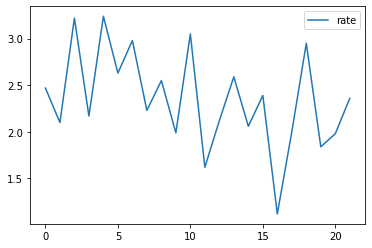

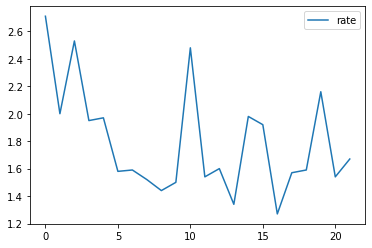

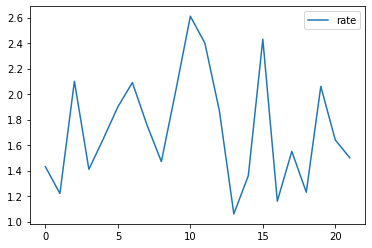

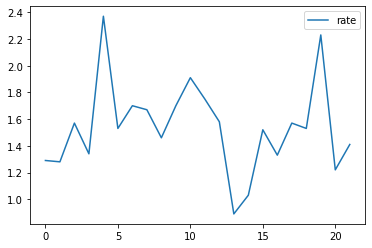

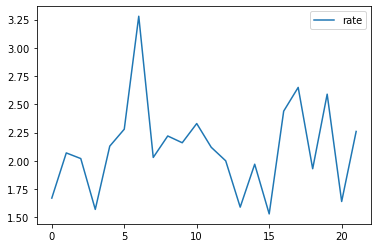

In [24]:
for period in ['EM', 'AM', 'MD', 'PM', 'EV']:
    test = error_df[error_df['period'] == period]
    
    test.sort_values(by = 'date').reset_index().plot(y = 'rate')


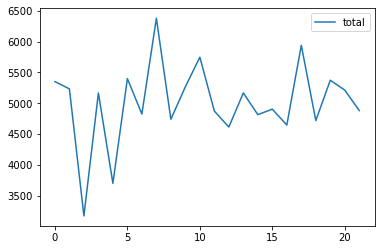

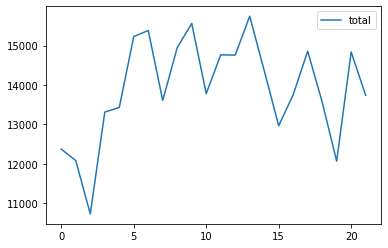

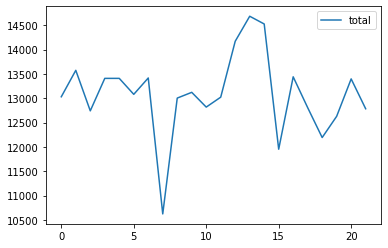

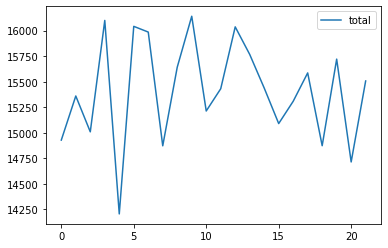

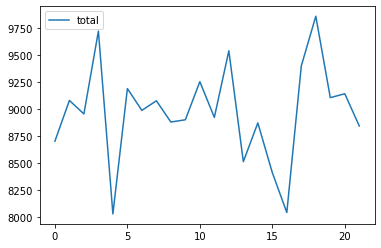

In [25]:
for period in ['EM', 'AM', 'MD', 'PM', 'EV']:
    test = error_df[error_df['period'] == period]
    
    test.sort_values(by = 'date').reset_index().plot(y = 'total')

In [26]:
error_df.to_csv('train_arrival_error.csv', index = False)

In [27]:
error_df

,date,period,total,non_seq,long_link,short_link,error,rate
0,2019-12-27,AM,13570,214,0,2,216,1.59
1,2019-12-09,AM,13610,207,0,0,207,1.52
2,2019-12-05,AM,15231,230,0,10,240,1.58
3,2019-12-02,AM,10731,262,0,9,271,2.53
4,2019-11-29,AM,12082,242,0,0,242,2.00
...,...,...,...,...,...,...,...,...
105,2020-01-02,MD,13398,216,0,4,220,1.64
106,2020-01-03,PM,15507,218,0,1,219,1.41
107,2020-01-02,PM,14714,176,0,4,180,1.22
108,2020-01-03,EV,8846,197,0,3,200,2.26


In [28]:
date

'2020-01-02'